In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold, learning_curve, GridSearchCV
from imblearn.over_sampling import SMOTE
import shap

pd.set_option("display.max_columns", None)
from functions import *
import warnings
warnings.filterwarnings('ignore')

### Add Labels to Data

In [2]:
df_raw = pd.read_parquet("Data/Cleaned/after_kriging.parquet")
df = pd.read_parquet('Data/Cleaned/post_feat_engineering.parquet')
labels = pd.read_parquet('Data/Cleaned/labels_may5.parquet')

df = df.merge(labels[['GEOID','pred_year','label']], on=['GEOID','pred_year'], how='left')

# remove observations with very small population
small_pop = df_raw[df_raw.total_pop <20].GEOID.unique()
df = df[df.GEOID.isin(small_pop)==False]

df['lag_ever_gentrified'] = df['lag_ever_gentrified'].replace(-1,2)  # TODO fix this in feature engineering

### Split Pred Set and Training set

In [7]:
# Split train/test/pred Set
pred_set = df[df.pred_year.isin(['2024','2025','2026','2027'])]
train_test_set_full = df[df.pred_year.isin(['2024','2025','2026','2027'])==False]

# limit train/test sets to vulnerable/gentrified tracts only
train_test_set = train_test_set_full[train_test_set_full.label!=0]

# define feature set and split data
feat = ['total_pop', 'percent_hh_income_assist', 'percent_hh_snap',
       'percent_hh_english', 'percent_work_agriculture',
       'percent_work_construction', 'percent_work_retail',
       'percent_work_finance', 'percent_work_stem', 'percent_work_edu_health',
       'percent_work_art', 'percent_out_of_county',
       'percent_moved_within_county', 'percent_public_transit',
       'percent_drive_commute', 'percent_bike_commute', 'percent_walk_commute',
       'percent_wfh', 'percent_white', 'percent_black', 'percent_native',
       'percent_asian', 'percent_pacific', 'percent_latino',
       'percent_bachelors', 'percent_grad', 'percent_born_citizen',
       'percent_naturalized_citizen', 'percent_not_citizen',
       'percent_same_house_1yr', 'percent_out_of_state', 'med_income',
       'med_rent_acs', 'med_age', 'med_value',
       'percent_hh_electric', 'percent_hh_solar', 'med_hh_age',
       'med_hh_tenure', 'num_citibike_rides', 'num_trees', 'med_rent',
       'num_affordable_hous_built', 'num_bikelanes','percent_hh_rented',
       'num_evictions_commercial', 'num_evictions_residential', 'park_acres',
       'num_parks', 'lag_vulnerable','lag_ever_gentrified']

# labels
y_train_test = train_test_set['label']

# features
X_train_test = train_test_set[feat]

# Apply SMOTE to the training data to upsample minority class
smote = SMOTE(sampling_strategy='auto')
X_train_test, y_train_test = smote.fit_resample(X_train_test, y_train_test)


### Train with Cross Validation to report performance

In [8]:
# Random Forest

forest = RandomForestClassifier(n_estimators=1000, random_state=65, max_features='log2')

# Learning Curves
# train_sizes, train_scores, val_scores = learning_curve(
#     forest, 
#     X_train_test, y_train_test,
#     train_sizes=np.linspace(0.1, 1.0, 10),
#     cv=5,    # 5-fold cross-validation
#     scoring='f1',
#     n_jobs=-1
# )
# # Compute means and std deviations
# train_mean = np.mean(train_scores, axis=1)
# val_mean = np.mean(val_scores, axis=1)
# # Plot
# plt.plot(train_sizes, train_mean, label="Training score")
# plt.plot(train_sizes, val_mean, label="Validation score")
# plt.xlabel("Training Set Size")
# plt.ylabel("F1")
# plt.title("Learning Curves (F1)")
# plt.legend()
# plt.grid(True)
# plt.show()

kf = KFold(n_splits=5, shuffle=True, random_state=65)
cv_scores = cross_val_score(forest, X_train_test, y_train_test, cv=kf, scoring="f1" )
print("CV Scores:", cv_scores)
print("Mean F1:", np.mean(cv_scores))


CV Scores: [0.86099865 0.85520974 0.85529716 0.85237484 0.88020833]
Mean F1: 0.8608177447724163


In [5]:
# Feature importances
forest.fit(X_train_test, y_train_test)
sorted(list(zip(forest.feature_importances_, X_train_test.columns)), reverse=True)[:20]


[(0.10275223595912081, 'percent_white'),
 (0.04414688327151188, 'lag_ever_gentrified'),
 (0.039448122427142074, 'percent_bachelors'),
 (0.03822473224722685, 'med_rent_acs'),
 (0.03502008577938522, 'med_rent'),
 (0.032543263953978295, 'med_income'),
 (0.026068610077422345, 'percent_bike_commute'),
 (0.025198212441884447, 'percent_grad'),
 (0.024294451273755104, 'num_trees'),
 (0.023294676821215027, 'percent_black'),
 (0.0218544895986704, 'percent_asian'),
 (0.020707643818097102, 'percent_public_transit'),
 (0.020613683598729903, 'percent_latino'),
 (0.020521133263614835, 'percent_hh_rented'),
 (0.020502299229002076, 'percent_work_stem'),
 (0.020351415917793134, 'percent_out_of_state'),
 (0.019681594883563868, 'percent_hh_english'),
 (0.018187003230548244, 'percent_wfh'),
 (0.017925600206727677, 'med_value'),
 (0.01790115014520746, 'med_hh_tenure')]

### Retrain on All Data for Final Preds

In [6]:
# final preds for 2024-2027

# retrain on full training data
forest.fit(X_train_test, y_train_test)
y_train_test_pred = forest.predict(X_train_test)  # optionally look at training performance

# predict 2024-27
X_pred = pred_set[feat]
y_final_pred = forest.predict(X_pred)
pred_set['preds'] = y_final_pred
pred_set['preds'] = np.where(pred_set['label']==0, 0, pred_set['preds'])  # change pred for non-eligible tracts to 0
pred_set.rename(columns={'pred_year':'year'}, inplace=True)


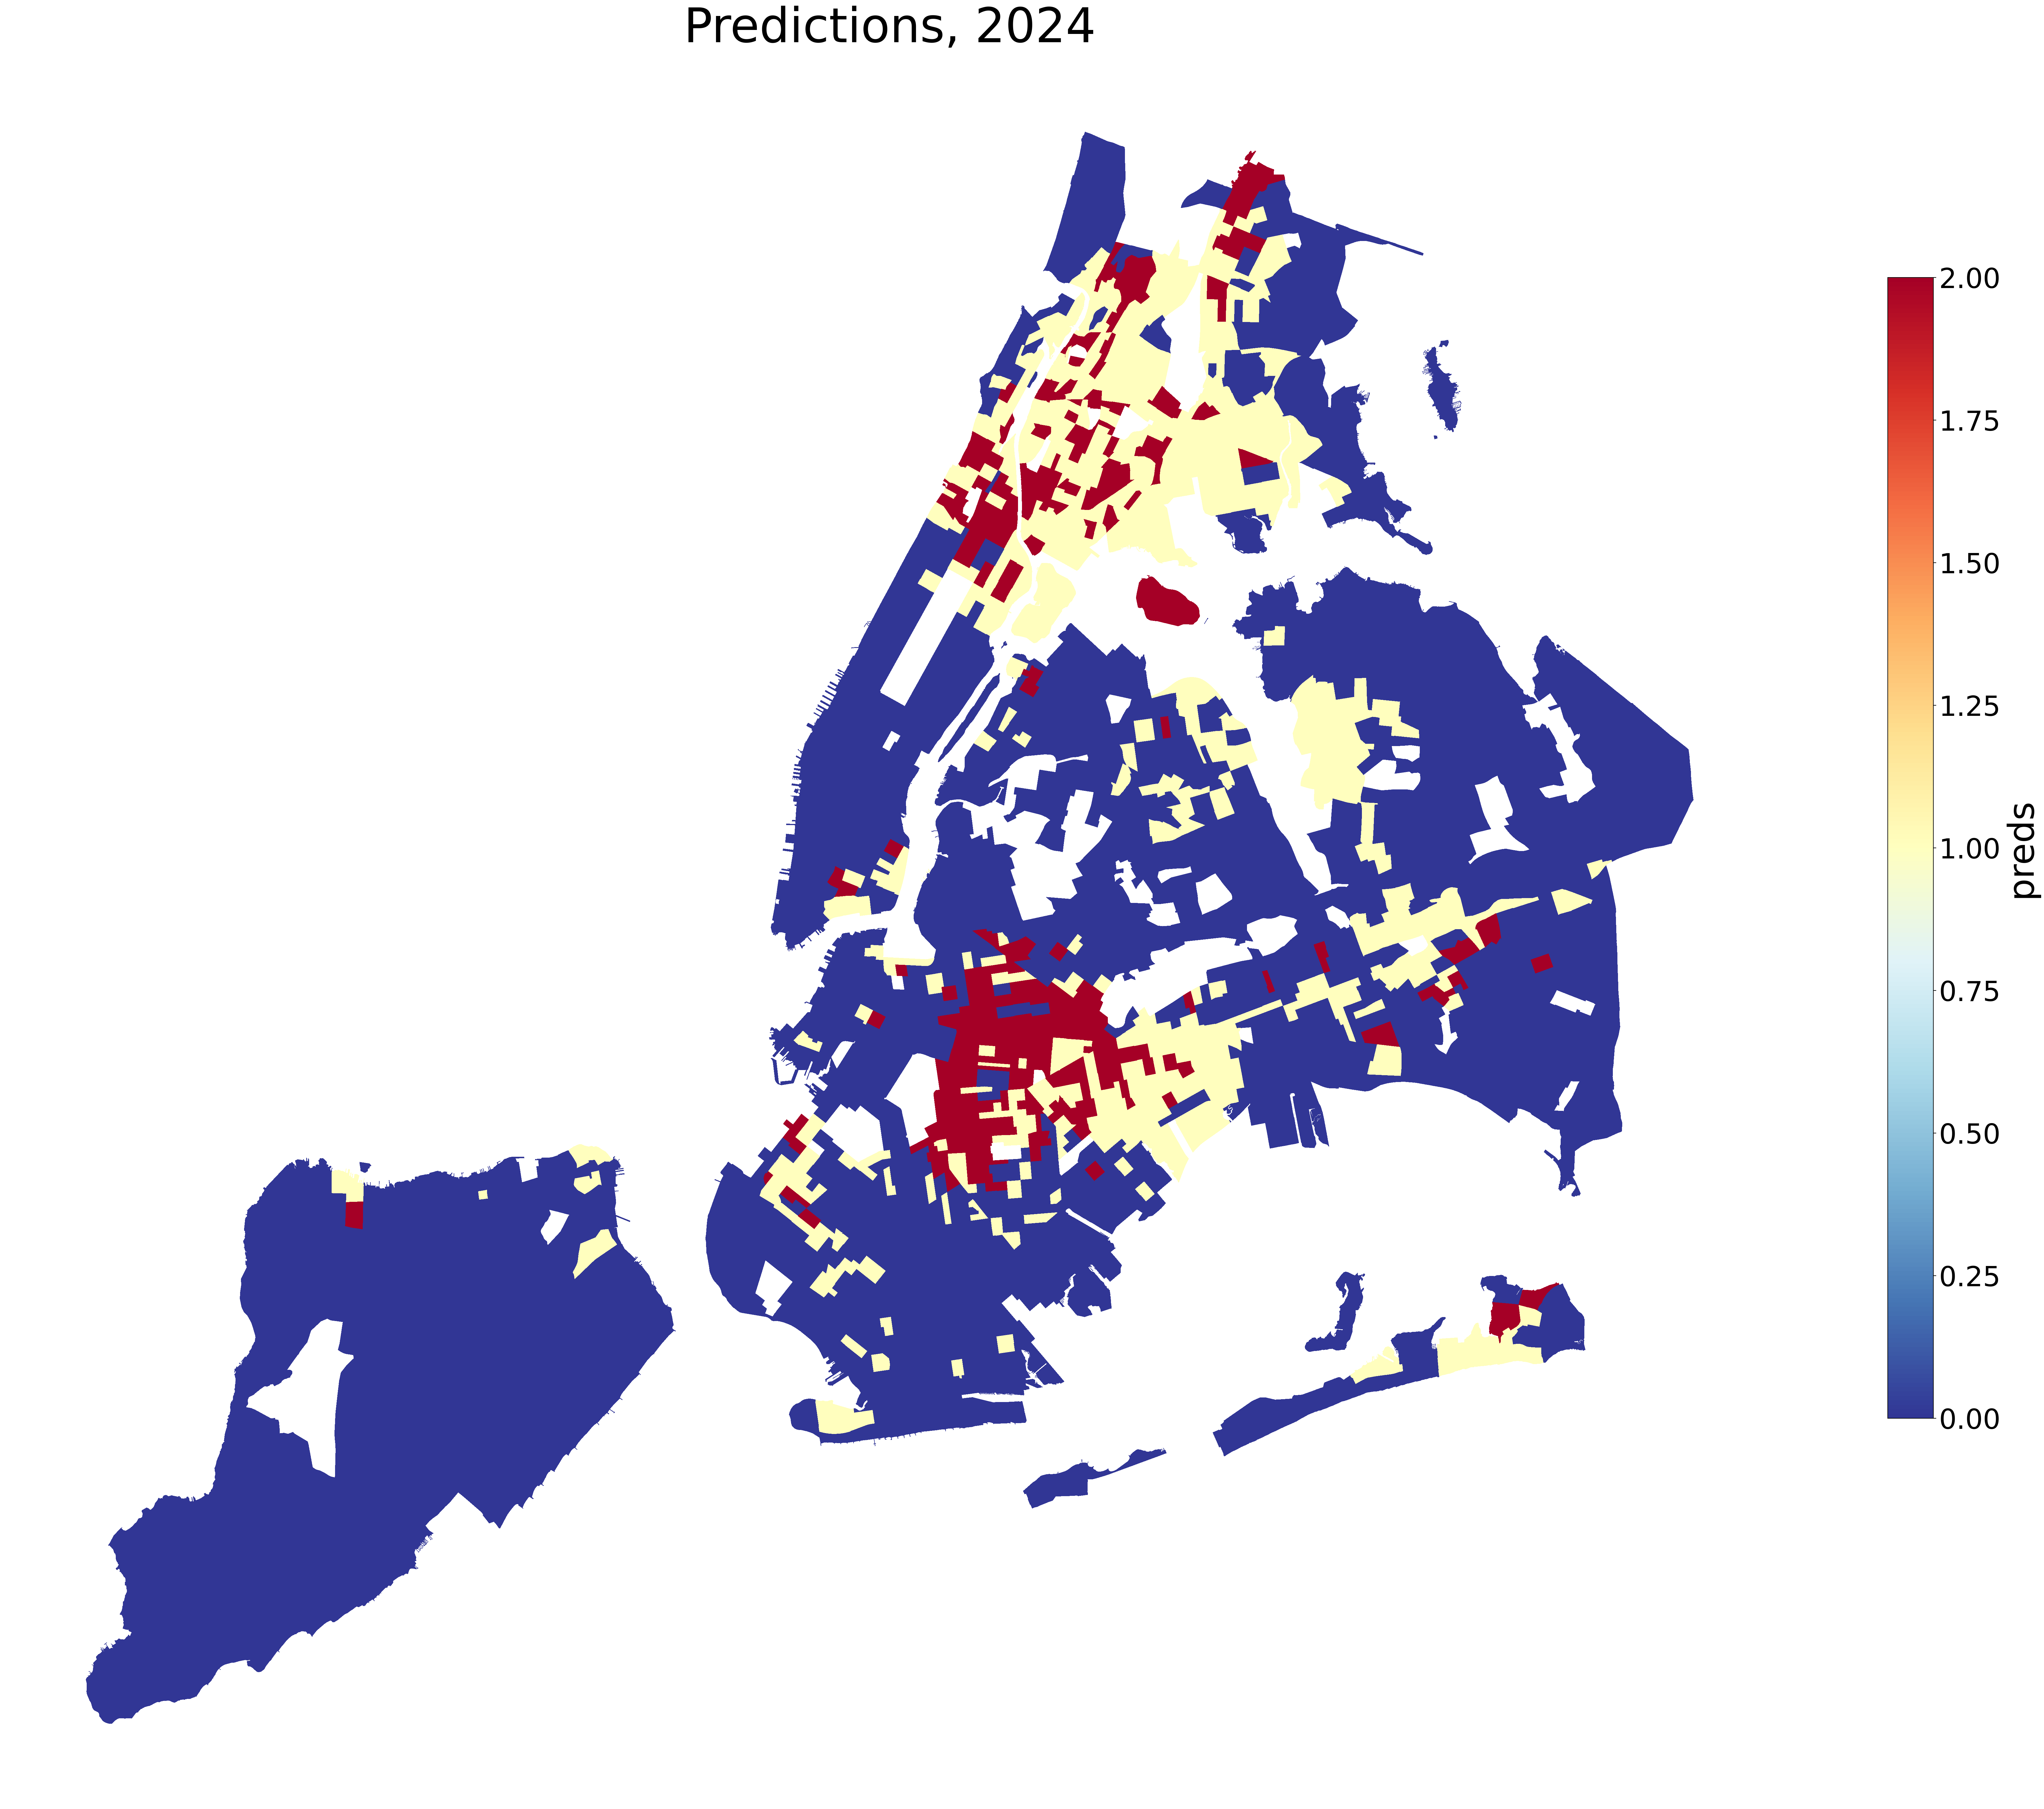

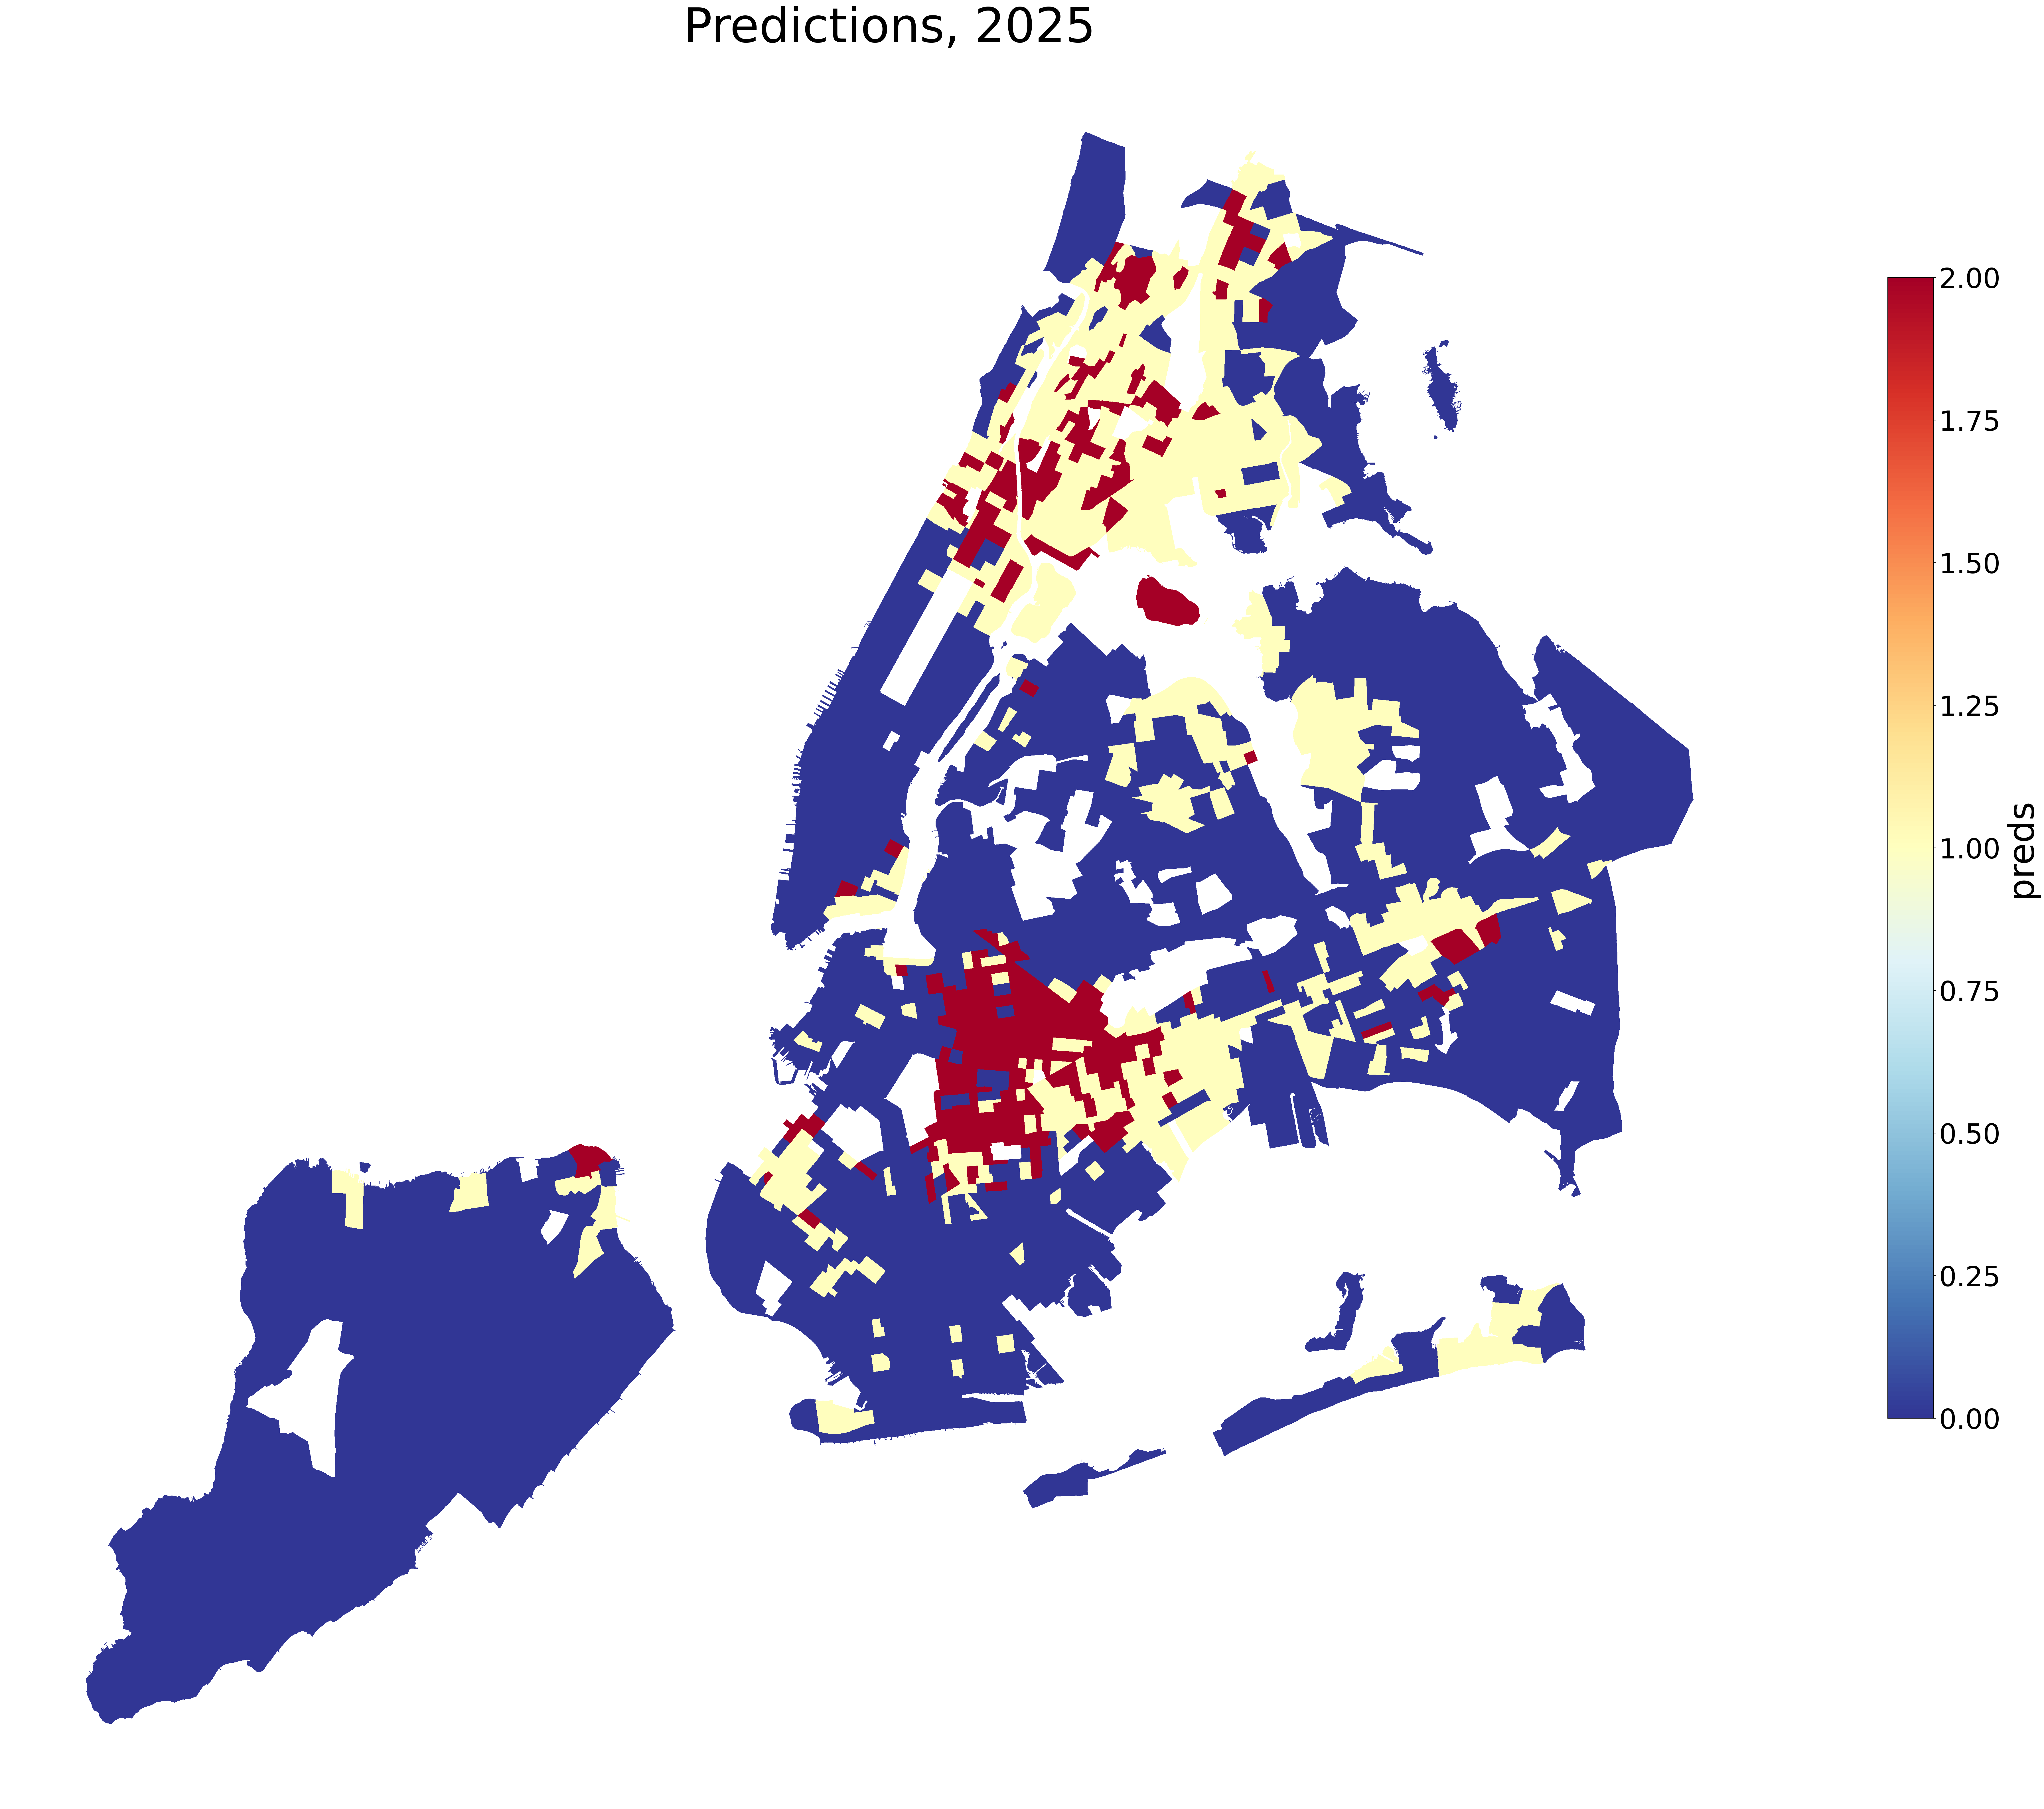

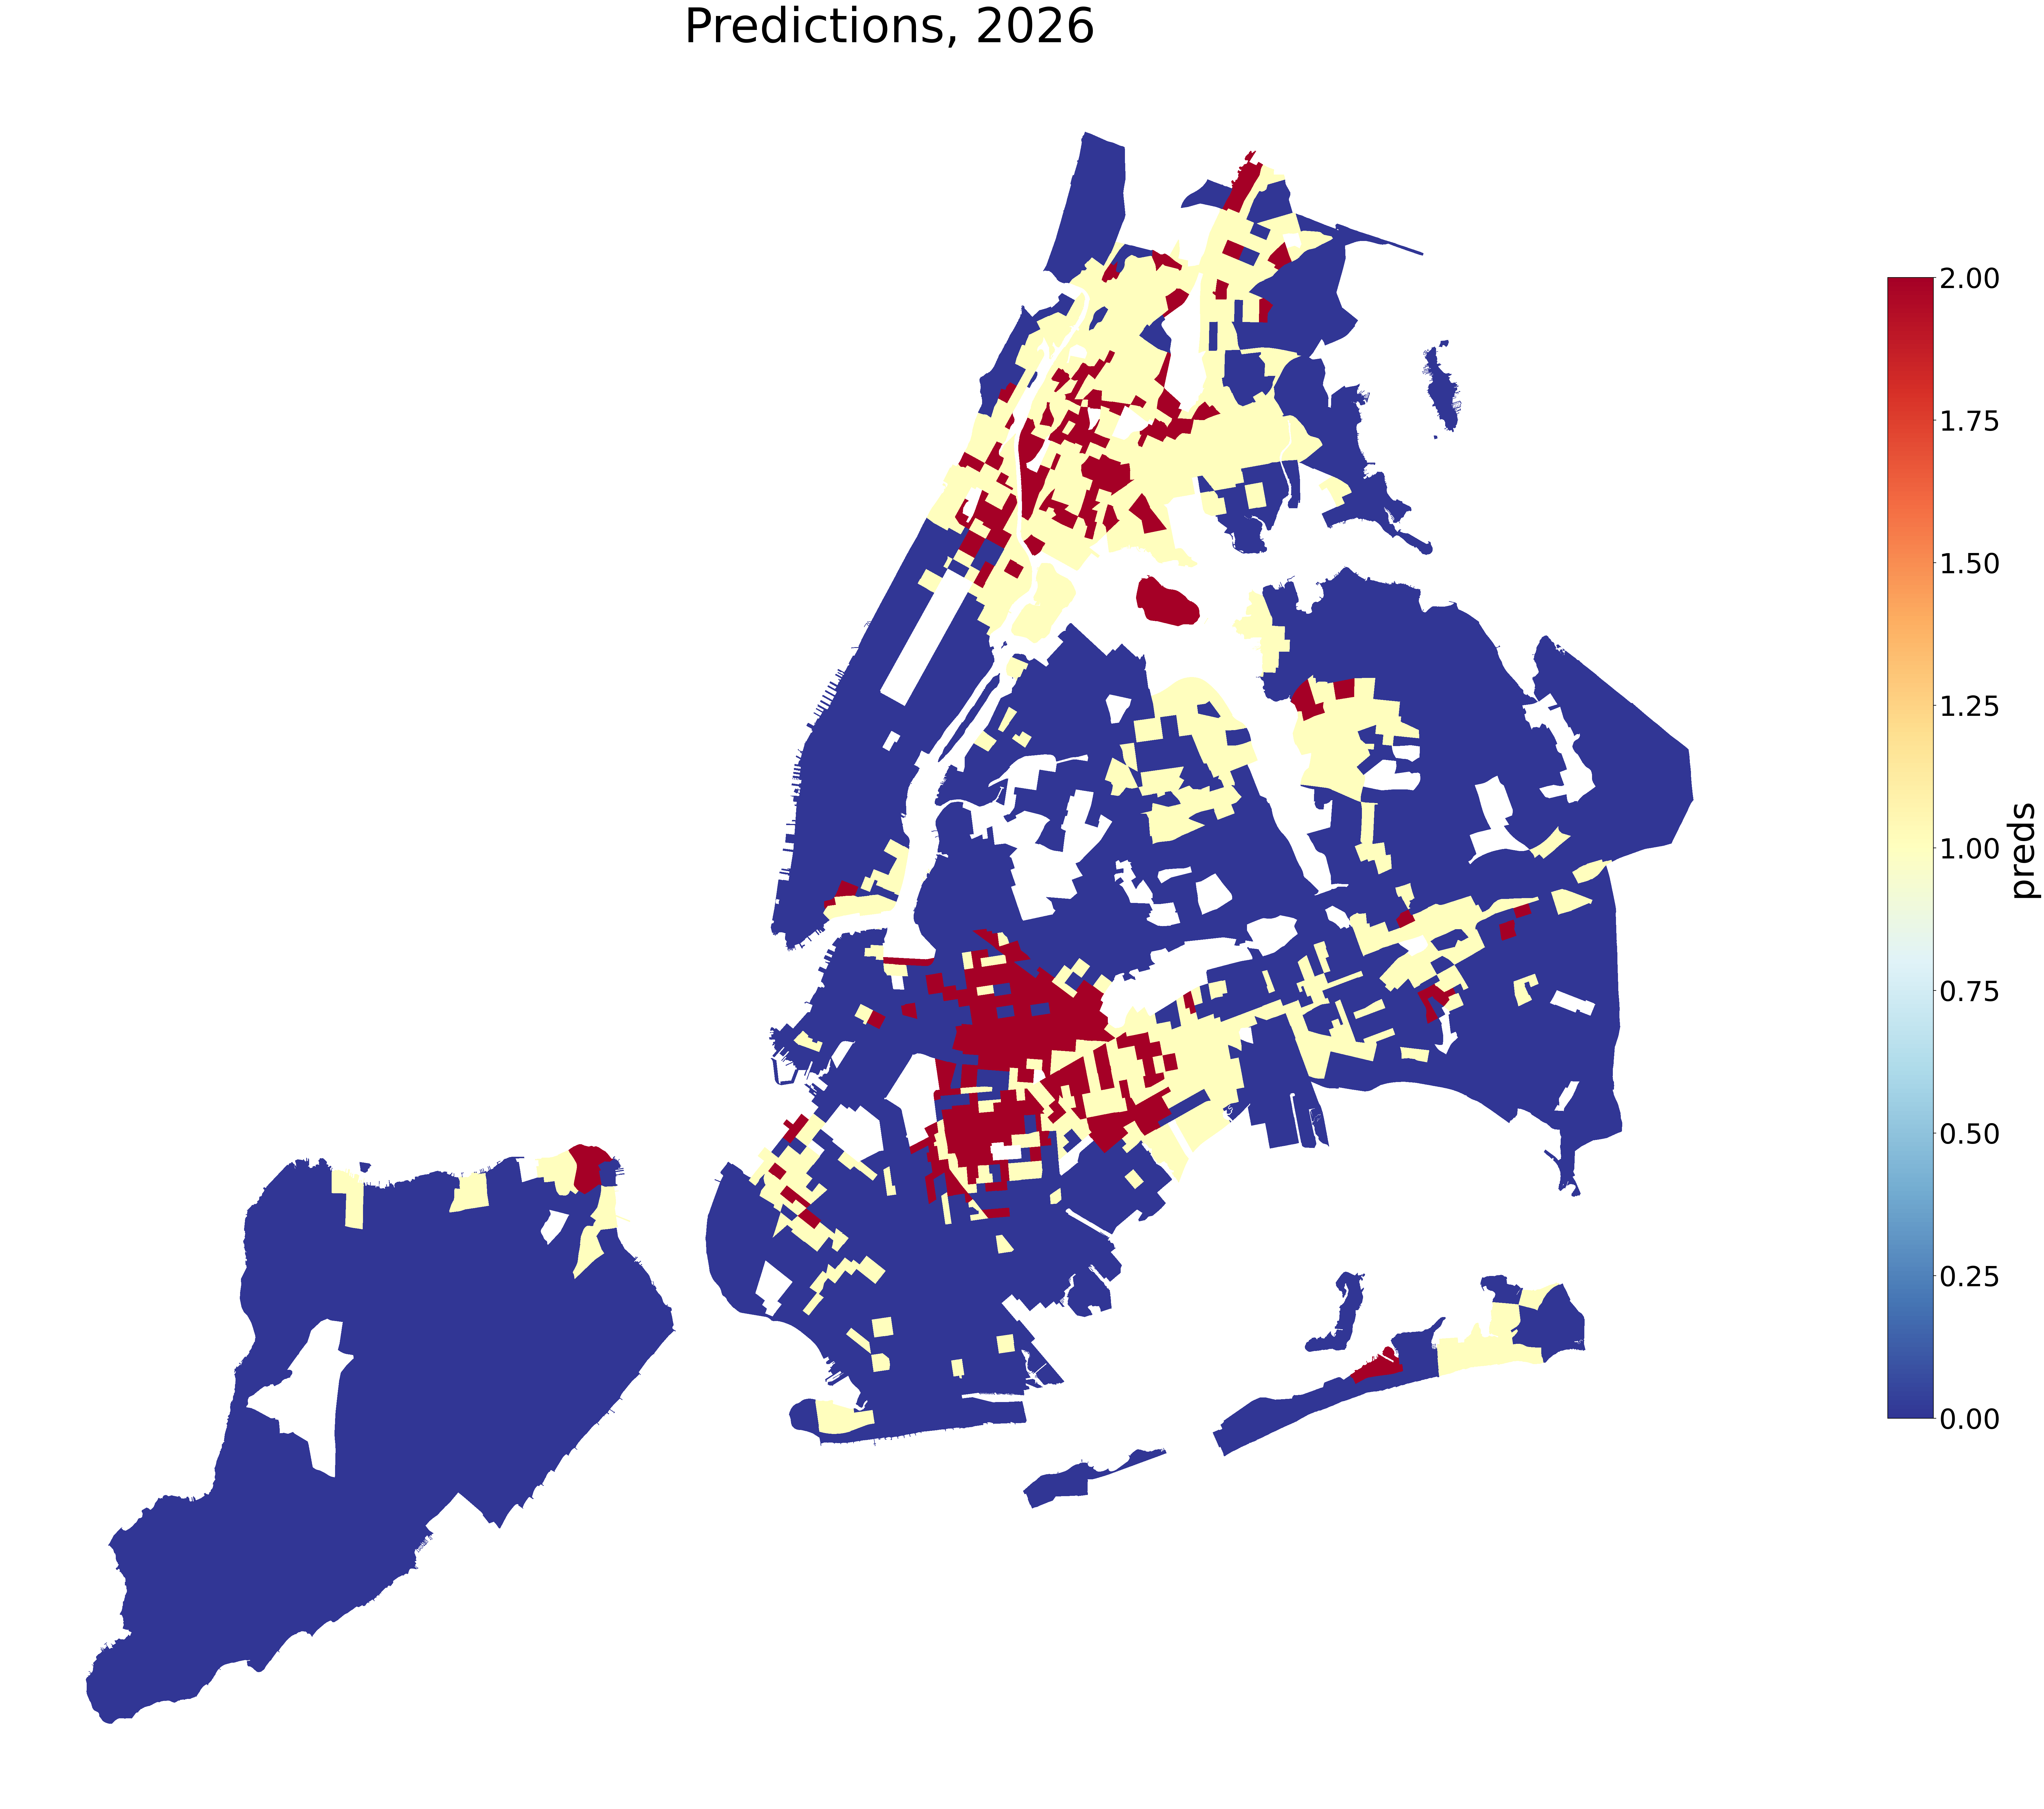

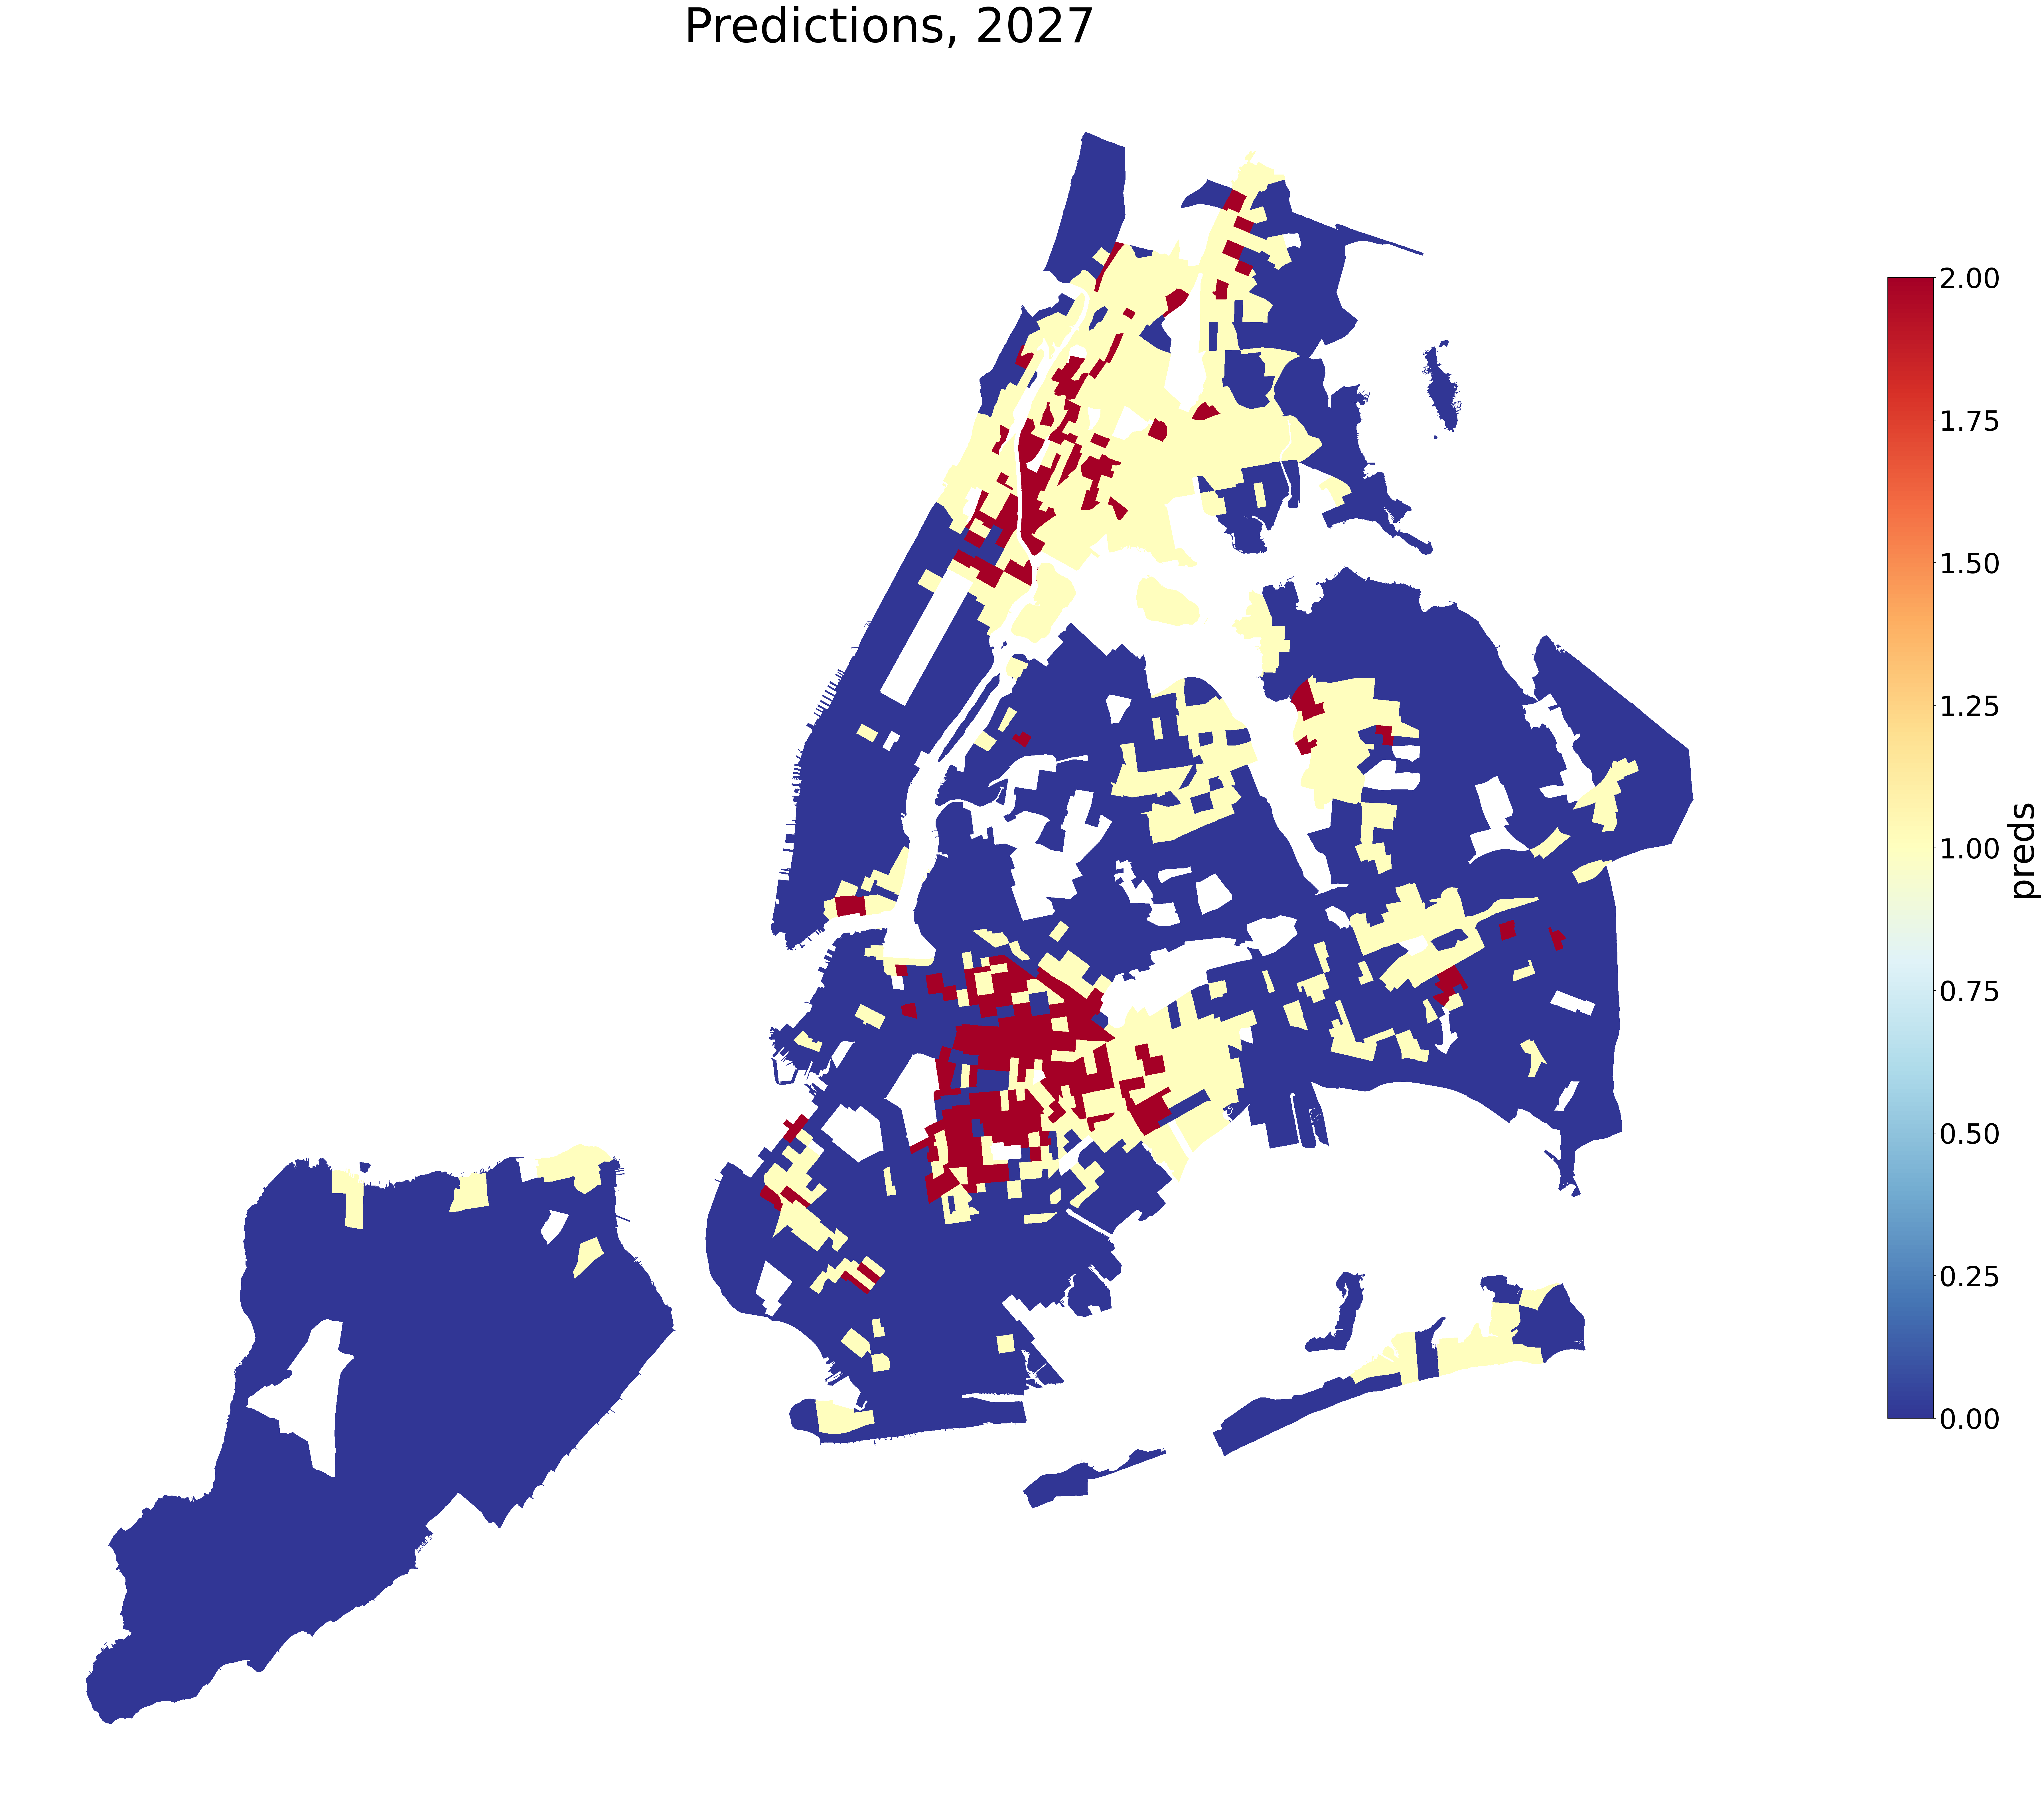

In [7]:
# visualize preds
choropleth(pred_set,'preds',['2024','2025','2026','2027'], cmap='RdYlBu_r', title='Predictions', save_img=True)

In [268]:
# pred_set.to_parquet('Data/Cleaned/future_preds.parquet')

## Individual Year Predictions
No cross validation used

In [81]:
# Split train/test/pred Set
train_set_full = df[df.pred_year.isin(['2022','2020','2021'])]
test_set_full = df[df.pred_year.isin(['2023'])]

# add our case study Census Tracts to teh test set to inspect Shap values later
set_to_move = train_set_full[train_set_full.GEOID.isin(['36047022900','36061016600','36047044300'])]
train_set_full.drop(set_to_move.index, inplace=True)
test_set_full = pd.concat([test_set_full, set_to_move])

# limit train/test sets to vulnerable/gentrified tracts only
train_set = train_set_full[train_set_full.label!=0]
test_set = test_set_full[test_set_full.label!=0]

# define feature set and split data
feat = ['total_pop', 'percent_hh_income_assist', 'percent_hh_snap',
       'percent_hh_english', 'percent_work_agriculture',
       'percent_work_construction', 'percent_work_retail',
       'percent_work_finance', 'percent_work_stem', 'percent_work_edu_health',
       'percent_work_art', 'percent_out_of_county',
       'percent_moved_within_county', 'percent_public_transit',
       'percent_drive_commute', 'percent_bike_commute', 'percent_walk_commute',
       'percent_wfh', 'percent_white', 'percent_black', 'percent_native',
       'percent_asian', 'percent_pacific', 'percent_latino',
       'percent_bachelors', 'percent_grad', 'percent_born_citizen',
       'percent_naturalized_citizen', 'percent_not_citizen',
       'percent_same_house_1yr', 'percent_out_of_state', 
       'med_rent_acs', 'med_age', 'med_value','med_income','med_rent',
       'percent_hh_electric', 'percent_hh_solar', 'med_hh_age',
       'med_hh_tenure', 'num_citibike_rides', 'num_trees', 
       'num_affordable_hous_built', 'num_bikelanes','percent_hh_rented',
       'num_evictions_commercial', 'num_evictions_residential', 'park_acres',
       'num_parks', 'lag_vulnerable','lag_ever_gentrified']

# labels
y_train = train_set['label']
y_test = test_set['label']

# features
X_train = train_set[feat]
X_test = test_set[feat]

# Apply SMOTE to the training data to upsample minority class
smote = SMOTE(sampling_strategy='auto')
X_train, y_train = smote.fit_resample(X_train, y_train)


In [82]:
###### Fit the Model
forest_yr = RandomForestClassifier(n_estimators=100, random_state=65)
forest_yr.fit(X_train, y_train)
y_train_pred = forest_yr.predict(X_train)
y_test_pred = forest_yr.predict(X_test)
y_probs = forest_yr.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

test_set['preds'] = y_test_pred
test_set_full = pd.concat([test_set, test_set_full[test_set_full.label==0]])
test_set_full['year'] = '2023'
test_set_full['preds'].fillna(0, inplace=True)

# performance scores
train_score = precision_score(y_train, y_train_pred)
test_score =  precision_score(y_test, y_test_pred)
print("Train Score:", train_score)
print("Test Score:", test_score)

# Compute ROC curve and AUC
y_test = np.where(y_test==2,1,0)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print("AUC of ROC Curve:", roc_auc)

# visualize preds
# choropleth(test_set_full,'preds',['2023'], cmap='RdYlBu_r',title='Predictions', save_img=False)
# choropleth(test_set_full,'label',['2023'], cmap='RdYlBu_r',title='Ground Truth', save_img=False)


Train Score: 1.0
Test Score: 0.8592132505175983
AUC of ROC Curve: 0.8918504540629791


In [83]:
# test_set.to_parquet('Data/Cleaned/2020_preds.parquet')

### ROC Curve

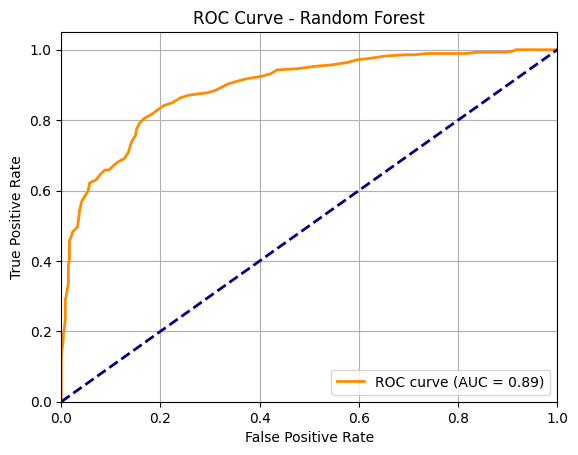

In [84]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Shap Values

 98%|===================| 1503/1532 [00:39<00:00]        

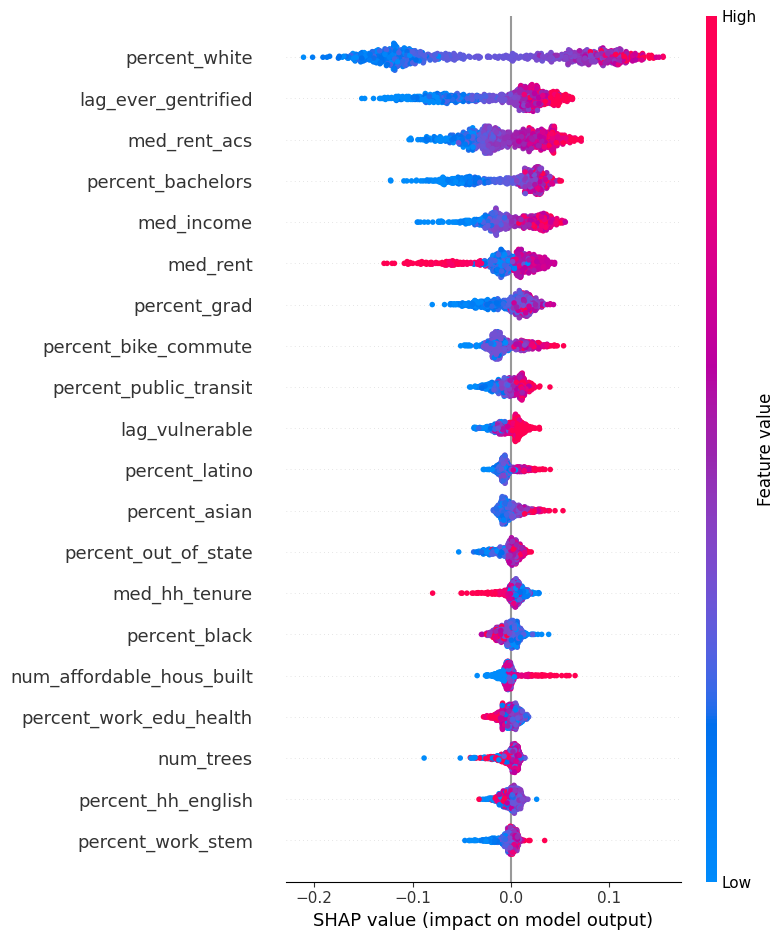

In [85]:
explainer = shap.Explainer(forest_yr, X_train) 
shap_values = explainer(X_test)

# Choose the class to explain (1=gentrifying)
class_idx = 1
shap_class1_values = shap_values[:, :, class_idx]

# Plot summary
shap.summary_plot(shap_class1_values, X_test, plot_type='dot', show=False);
# plt.savefig('Images/SHAP.png', transparent=True)


## Look at individual observations

In [99]:
test_set.reset_index(drop=True, inplace=True)
cases = test_set[test_set.GEOID.isin(['36047022900','36061016600','36047044300'])]


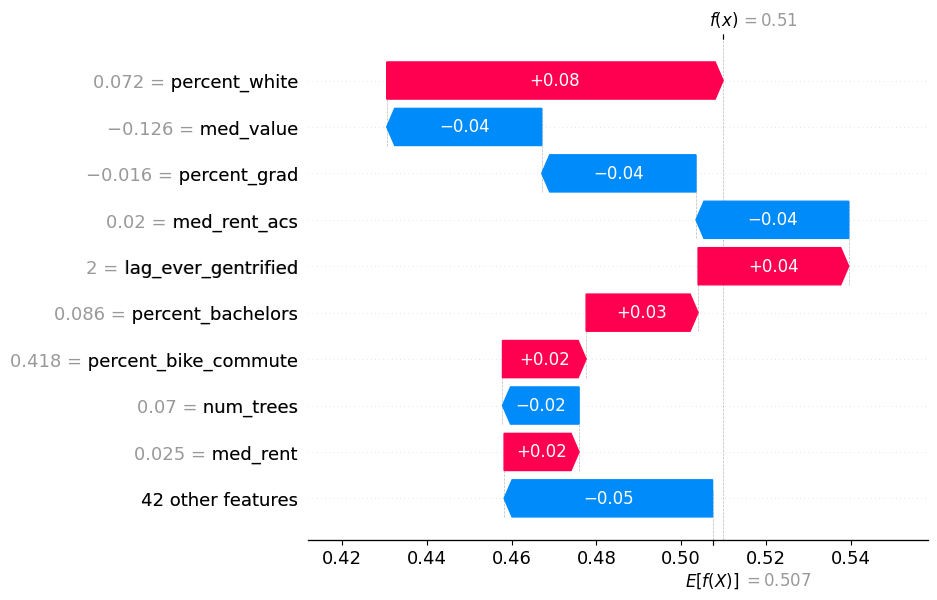

In [95]:
# Bed Stuy - 36047022900
shap.plots.waterfall(shap_class1_values[761])

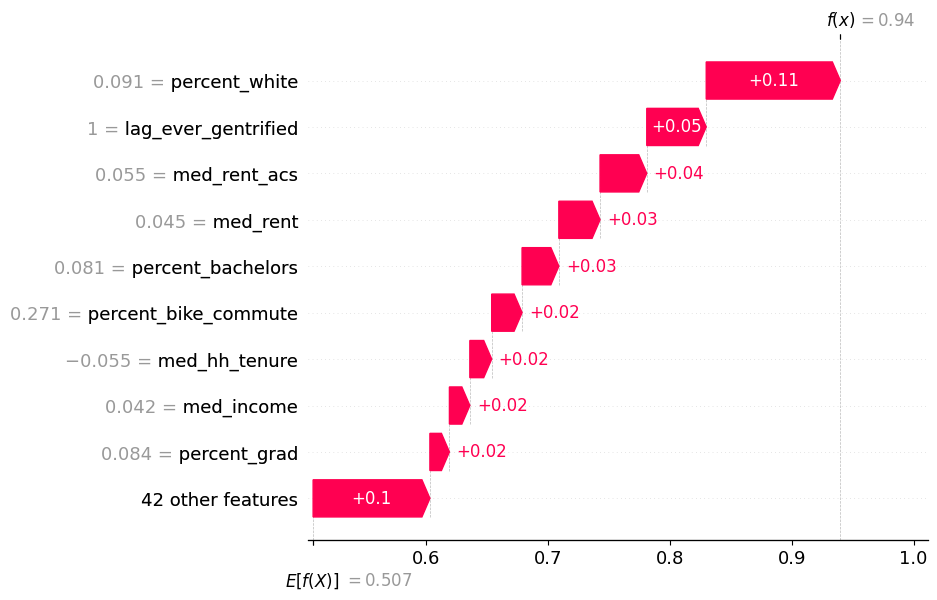

In [90]:
# Bushwick - 36047044300
shap.plots.waterfall(shap_class1_values[762])

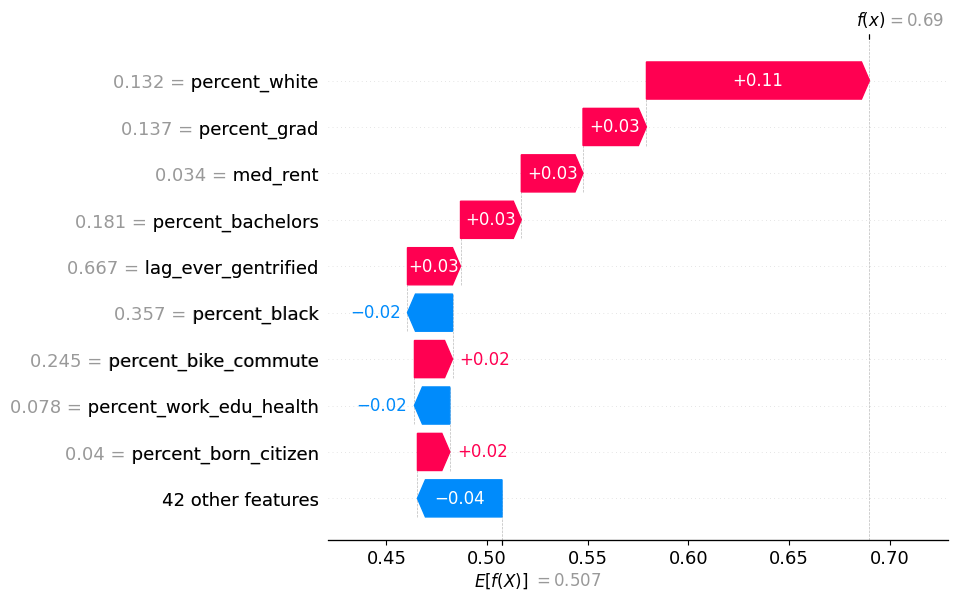

In [91]:
# Harlem - 36061016600
shap.plots.waterfall(shap_class1_values[763])

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

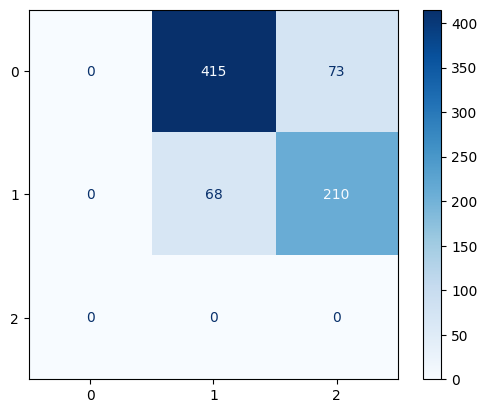

In [100]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_set['label'].unique())
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title("Confusion Matrix")
plt.show()